In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import pearsonr, spearmanr
from scipy import stats
from IPython.display import display, HTML
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split
from datetime import datetime
from statsmodels.formula.api import ols
from statsmodels.stats.api import anova_lm



In [2]:
#locating the dataset
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

df_trustpilot = pd.read_csv('data/data_trustpilot.csv', engine='python')

df_trustpilot.head()


,username,number_reviews,location,rating,text,date_of_experience,date_posted,subject,answer,company,verification,answered,local_hour,local_date_posted,days_between_experience_and_post,day_of_week_posted
0,Rob Crane,2,CA,5,The company rep I worked with made my transaction smooth and quick. The samples were so helpful and the item shipping was relatively very fast. I will be a repeat customer.,2024-06-15,2024-10-23 04:17:44,The company rep I worked with made my…,0,Flashbay,0,0,21,2024-10-22,129,1
1,Pat Anderson,1,US,5,I highly recommend using Flashbay. Immediately after ordering I heard from them and they were attentive to every little detail. I had notebooks shipped to Alaska for a conference and they arrived in perfect condition and delivered on time! Can't say enough good things about Flashbay!,2024-10-16,2024-10-16 19:34:05,I highly recommend using Flashbay,0,Flashbay,1,0,12,2024-10-16,0,2
2,Margarita Orlova,1,CZ,5,"I had the pleasure of working with Shelby Gibson on a large order that we needed to ship to different locations. Shelby was very responsive, very kind and helpful. The order process was smooth and the final products look great. Only positive feedback from my side.",2024-10-10,2024-10-17 10:27:44,Great customer service,0,Flashbay,1,0,10,2024-10-17,7,3
3,Paola Rivas,1,US,5,"I had a fantastic experience with Brian Truong. He was attentive, truly understood my needs, and provided all the support I needed. Excellent customer service—thank you!",2024-10-21,2024-10-21 22:38:50,Outstanding Support and Attentive Service,0,Flashbay,1,0,15,2024-10-21,0,0
4,Fiona Mckelvey Keenan,3,CA,5,"My number-one go-to for computer accessories. Rachel was superb. She responded to my every request immediately, and her communication was satisfactory enough to get all the answers I wanted. Highly recommend!",2024-07-11,2024-10-23 04:09:05,My number-one go-to for computer…,0,Flashbay,0,0,21,2024-10-22,103,1


In [ ]:
print(df_trustpilot['verification'].unique())

# Verification currently has 4 values. In order to simplify this variable, we will perform binary encoding.
# ['Verified' 'Not Verified' 'Redirected' 'Invited']
# 'Verified' = 1
# 'Not Verified', 'Redirected', 'Invited' = 0 
# 'Not Verified', 'Redirected', 'Invited' were all encoded 0 as they are not verified by the Trustpilot website

verification_map = {
    'Verified': 1,
    'Not Verified': 0,
    'Redirected': 0,
    'Invited': 0
}

df_trustpilot['verification_encoded'] = df_trustpilot['verification'].map(verification_map)

df_trustpilot = df_trustpilot.drop('verification', axis=1)

df_trustpilot['verification'] = df_trustpilot['verification_encoded']
df_trustpilot = df_trustpilot.drop('verification_encoded', axis=1)

In [3]:
#Split set into numeric, categorical and datetime variables
#Provide statistical metrics for numeric variables

numeric_variables = df_trustpilot.select_dtypes(include = ['int', 'float'])
categorical_variables = df_trustpilot.select_dtypes(include=['object']) 
datetime_variables = df_trustpilot.select_dtypes(include=['datetime64'])

print("Numeric variables are: ", numeric_variables.columns)
print("Categorical variables are: ", categorical_variables.columns)
print("Datetime variables are: ", datetime_variables.columns)

print(numeric_variables.describe())


Numeric variables are:  Index(['number_reviews', 'rating', 'verification', 'answered', 'local_hour',
       'days_between_experience_and_post', 'day_of_week_posted'],
      dtype='object')
Categorical variables are:  Index(['username', 'location', 'text', 'date_of_experience', 'date_posted',
       'subject', 'answer', 'company', 'local_date_posted'],
      dtype='object')
Datetime variables are:  Index([], dtype='object')
       number_reviews        rating  verification      answered    local_hour  \
count    73001.000000  73001.000000  73001.000000  73001.000000  73001.000000   
mean         3.881522      3.495363      0.660991      0.252079     11.877837   
std         10.242879      1.706886      0.473376      0.434209      4.676573   
min          1.000000      1.000000      0.000000      0.000000      0.000000   
25%          1.000000      1.000000      0.000000      0.000000      8.000000   
50%          1.000000      4.000000      1.000000      0.000000     11.000000   
75%   

In [ ]:
#Creates a new column called 'answered' which returns 1 if an answer to a user review was submitted, 0 if not
df_trustpilot['answered'] = np.where(df_trustpilot['answer'] == 0, 0, 1)

display(df_trustpilot.head())


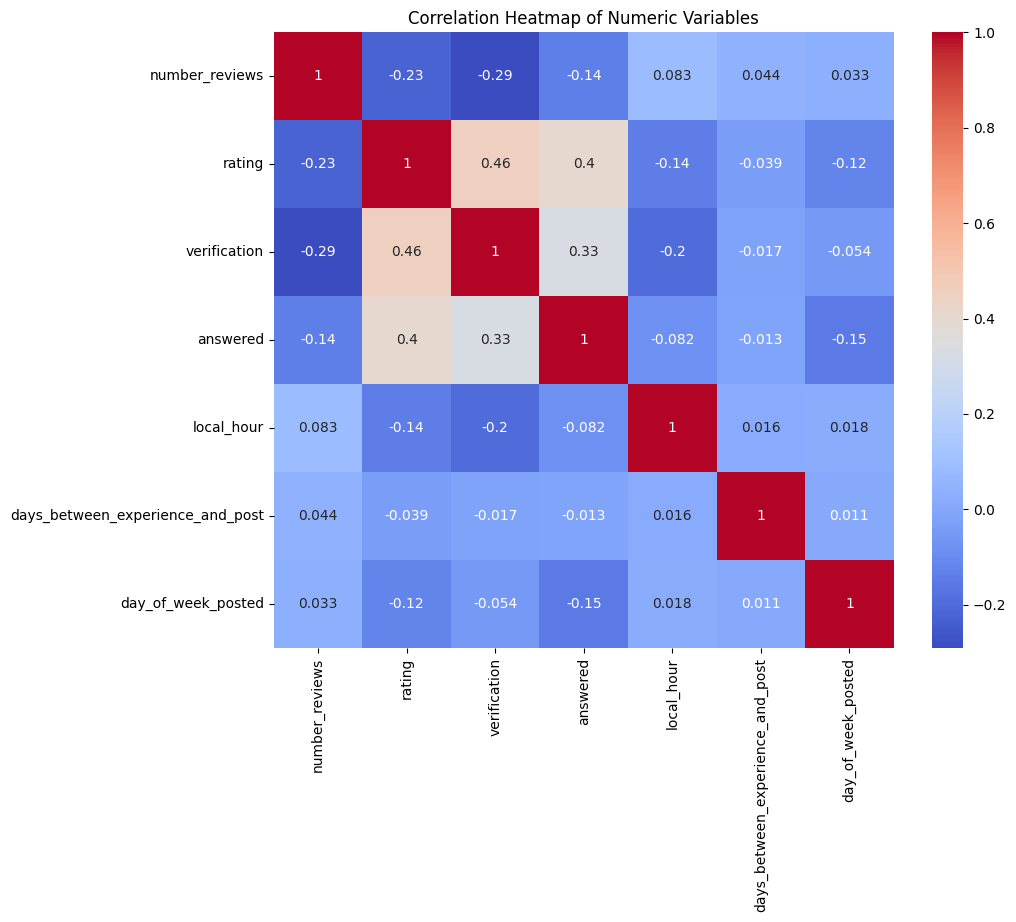

In [5]:
# Correlation heatmap for numeric variables

plt.figure(figsize=(10, 8))
sns.heatmap(numeric_variables.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numeric Variables')
plt.show()

#Based on the heatmap, the only strong correlation that exists among the numeric variables is between rating and verification.

In [6]:
#Pearson and Spearman

def analyze_correlation_with_rating(column_name):
    if column_name not in df_trustpilot.columns:
        return f"Error: Column '{column_name}' not found in dataframe"
    
    # Calculate correlations
    pearson_coeff, pearson_p = pearsonr(df_trustpilot['rating'], df_trustpilot[column_name])
    spearman_coeff, spearman_p = spearmanr(df_trustpilot['rating'], df_trustpilot[column_name])
    
    # Format output
    output = []
    output.append(f"Correlation Analysis: rating vs {column_name}")
    output.append("=" * 50)
    output.append("Hypothesis:")
    output.append("H0: The two variables are uncorrelated")
    output.append("H1: The two variables are correlated")
    output.append("\nResults:")
    output.append("-" * 50)
    
    # Pearson Analysis
    output.append(f"Pearson coefficient: {pearson_coeff}")
    if abs(pearson_coeff) < 0.1:
        strength = "extremely weak/negligible"
    elif abs(pearson_coeff) < 0.3:
        strength = "weak"
    elif abs(pearson_coeff) < 0.5:
        strength = "moderate"
    else:
        strength = "strong"
    direction = "negative" if pearson_coeff < 0 else "positive"
    output.append(f"Negative sign indicates an inverse relationship but as the value is {strength}, "
                 f"this indicates a{strength} {direction} correlation.")
    
    output.append(f"\nPearson p_value: {pearson_p}")
    if pearson_p < 0.05:
        output.append("Value is smaller than the common significance level of 0.05. "
                     f"This indicates that the correlation, although {strength}, is statistically significant.")
    else:
        output.append("Value is larger than the common significance level of 0.05. "
                     "This indicates that the correlation is not statistically significant.")
    
    # Spearman Analysis
    output.append(f"\nSpearman coefficient: {spearman_coeff}")
    if abs(spearman_coeff) < 0.1:
        strength = "extremely weak/negligible"
    elif abs(spearman_coeff) < 0.3:
        strength = "weak"
    elif abs(spearman_coeff) < 0.5:
        strength = "moderate"
    else:
        strength = "strong"
    output.append(f"Negative sign indicates an inverse relationship and as the value is {strength}, "
                 f"this indicates a {strength} {direction} correlation.")
    
    output.append(f"\nSpearman p_value: {spearman_p}")
    if spearman_p < 0.05:
        output.append("Value is smaller than the common significance level of 0.05. "
                     f"This indicates that the correlation, although {strength}, is statistically significant.")
    else:
        output.append("Value is larger than the common significance level of 0.05. "
                     "This indicates that the correlation is not statistically significant.")
    
    # Conclusion
    output.append("\nConclusion:")
    output.append("-" * 50)
    if pearson_p < 0.05 or spearman_p < 0.05:
        output.append("H0 is rejected")
        output.append("H1 is confirmed")
    else:
        output.append("Failed to reject H0")
        
    # Additional insights
    if abs(abs(spearman_coeff) - abs(pearson_coeff)) > 0.1:
        output.append(f"\nThe difference between Pearson ({pearson_coeff:.3f}) and "
                     f"Spearman ({spearman_coeff:.3f}) suggests a non-linear relationship")
    
    # Practical interpretation
    output.append(f"\nAs {column_name} increases, ratings tend to "
                 f"{'decrease' if pearson_coeff < 0 else 'increase'}")
    output.append("While statistically significant, the relationship is "
                 f"{strength}")
    output.append("Keep for model training of a rating model")
    
    return "\n".join(output)

# Usage
print(analyze_correlation_with_rating('days_between_experience_and_post'))

# Get list of numeric columns excluding 'rating'
numeric_columns = df_trustpilot.select_dtypes(include=['int64', 'float64']).columns
numeric_columns = [col for col in numeric_columns if col != 'rating']

print("Starting correlation analysis for all numeric variables...")
print("=" * 80)

# Loop through each numeric column
for column in numeric_columns:
    display(HTML(f"<pre>{analyze_correlation_with_rating(column)}</pre>"))
    display(HTML("<hr>")) 


Correlation Analysis: rating vs days_between_experience_and_post
Hypothesis:
H0: The two variables are uncorrelated
H1: The two variables are correlated

Results:
--------------------------------------------------
Pearson coefficient: -0.0388811856705674
Negative sign indicates an inverse relationship but as the value is extremely weak/negligible, this indicates aextremely weak/negligible negative correlation.

Pearson p_value: 7.853550337971344e-26
Value is smaller than the common significance level of 0.05. This indicates that the correlation, although extremely weak/negligible, is statistically significant.

Spearman coefficient: -0.1390481014641766
Negative sign indicates an inverse relationship and as the value is weak, this indicates a weak negative correlation.

Spearman p_value: 0.0
Value is smaller than the common significance level of 0.05. This indicates that the correlation, although weak, is statistically significant.

Conclusion:
------------------------------------------

In [7]:
def analyze_anova_with_rating(df):
    # Get numeric columns except rating
    attributes = df.select_dtypes(include=['int64', 'float64']).columns
    attributes = [col for col in attributes if col != 'rating']
    
    # Store results and selected features
    results = {}
    feat_select = []
    
    print("ANOVA Analysis: Features vs Rating")
    print("=" * 50)
    
    # Analyze each feature
    for feature in attributes:
        try:
            # Perform ANOVA
            lm = ols('rating ~ {}'.format(feature), data=df).fit()
            table = anova_lm(lm)
            p_value = table['PR(>F)'].iloc[0]
            
            # If significant, add to selected features
            if p_value <= 0.05:
                feat_select.append(feature)
                results[feature] = p_value
                
        except Exception as e:
            print(f"Error analyzing {feature}: {str(e)}")
    
    # Create and display results table
    if feat_select:
        results_df = pd.DataFrame({
            'Feature': feat_select,
            'P-value': [results[f] for f in feat_select]
        }).sort_values('P-value')
        
        print("\nSelected Features (p ≤ 0.05):")
        print(results_df)
    
    return feat_select

# Usage:
selected_features = analyze_anova_with_rating(df_trustpilot)

ANOVA Analysis: Features vs Rating

Selected Features (p ≤ 0.05):
                            Feature        P-value
0                    number_reviews   0.000000e+00
1                      verification   0.000000e+00
2                          answered   0.000000e+00
3                        local_hour   0.000000e+00
5                day_of_week_posted  8.480174e-245
4  days_between_experience_and_post   7.853550e-26


In [8]:
#ANOVA 

def analyze_anova_with_rating(df):
    attributes = df.select_dtypes(include=['int64', 'float64']).columns
    attributes = [col for col in attributes if col != 'rating']
    
    results = {}
    feat_select = []
    output_text = []
    
    output_text.append("ANOVA Analysis: Features vs Rating")
    output_text.append("=" * 50)
    
    for feature in attributes:
        try:
            lm = ols('rating ~ {}'.format(feature), data=df).fit()
            table = anova_lm(lm)
            p_value = table['PR(>F)'].iloc[0]
            f_stat = table['F'].iloc[0]
            
            # Calculate effect size (eta-squared)
            ss_between = table['sum_sq'][0]
            ss_total = ss_between + table['sum_sq'][1]
            eta_squared = ss_between / ss_total
            
            # Store results
            results[feature] = {
                'p_value': p_value,
                'f_stat': f_stat,
                'eta_squared': eta_squared
            }
            
            # Interpret effect size
            if eta_squared < 0.01:
                effect_strength = "negligible"
            elif eta_squared < 0.06:
                effect_strength = "small"
            elif eta_squared < 0.14:
                effect_strength = "medium"
            else:
                effect_strength = "large"
            
            # Feature selection
            if p_value <= 0.05:
                feat_select.append(feature)
            
            # Output for each feature
            output_text.append(f"\nAnalysis for: {feature}")
            output_text.append("-" * 30)
            output_text.append(f"F-statistic: {f_stat:.4f}")
            output_text.append(f"P-value: {p_value:.4e}")
            output_text.append(f"Effect size (η²): {eta_squared:.4f}")
            output_text.append(f"Effect strength: {effect_strength}")
            output_text.append(f"Selected for model: {'Yes' if p_value <= 0.05 else 'No'}")
            
        except Exception as e:
            output_text.append(f"\nError analyzing {feature}: {str(e)}")
    
    # Summary
    output_text.append("\n" + "=" * 50)
    output_text.append("\nSummary:")
    output_text.append(f"Total features analyzed: {len(attributes)}")
    output_text.append(f"Features selected: {len(feat_select)}")
    output_text.append("\nSelected features:")
    for feat in feat_select:
        p_value = results[feat]['p_value']
        eta = results[feat]['eta_squared']
        output_text.append(f"- {feat}: p={p_value:.4e}, η²={eta:.4f}")
    
    print("\n".join(output_text))
    return results, feat_select

# Usage:
results, selected_features = analyze_anova_with_rating(df_trustpilot)

ANOVA Analysis: Features vs Rating

Analysis for: number_reviews
------------------------------
F-statistic: 3900.7607
P-value: 0.0000e+00
Effect size (η²): 0.0507
Effect strength: small
Selected for model: Yes

Analysis for: verification
------------------------------
F-statistic: 19416.4371
P-value: 0.0000e+00
Effect size (η²): 0.2101
Effect strength: large
Selected for model: Yes

Analysis for: answered
------------------------------
F-statistic: 13944.1896
P-value: 0.0000e+00
Effect size (η²): 0.1604
Effect strength: large
Selected for model: Yes

Analysis for: local_hour
------------------------------
F-statistic: 1506.3597
P-value: 0.0000e+00
Effect size (η²): 0.0202
Effect strength: small
Selected for model: Yes

Analysis for: days_between_experience_and_post
------------------------------
F-statistic: 110.5231
P-value: 7.8536e-26
Effect size (η²): 0.0015
Effect strength: negligible
Selected for model: Yes

Analysis for: day_of_week_posted
------------------------------
F-statis

/var/folders/fj/_k57h65963x0q_bf6vpz8cym0000gn/T/ipykernel_17898/1316868491.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ss_between = table['sum_sq'][0]
/var/folders/fj/_k57h65963x0q_bf6vpz8cym0000gn/T/ipykernel_17898/1316868491.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ss_total = ss_between + table['sum_sq'][1]
/var/folders/fj/_k57h65963x0q_bf6vpz8cym0000gn/T/ipykernel_17898/1316868491.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by positi

In [9]:
#ANOVA

def analyze_anova_with_rating(column_name):
    if column_name not in df_trustpilot.columns:
        return f"Error: Column '{column_name}' not found in dataframe"
    
    n_unique = df_trustpilot[column_name].nunique()
    if n_unique > 160:  
        return f"Error: Column '{column_name}' has too many unique values ({n_unique}) for meaningful ANOVA"
    
    # Perform one-way ANOVA
    categories = df_trustpilot[column_name].unique()
    rating_groups = [df_trustpilot.loc[df_trustpilot[column_name] == cat, 'rating'] for cat in categories]
    f_stat, p_value = stats.f_oneway(*rating_groups)
    
    # Calculate effect size (Eta-squared)
    groups = df_trustpilot.groupby(column_name)['rating']
    ss_between = sum(len(group) * ((group.mean() - df_trustpilot['rating'].mean()) ** 2) for name, group in groups)
    ss_total = sum((df_trustpilot['rating'] - df_trustpilot['rating'].mean()) ** 2)
    eta_squared = ss_between / ss_total
    
    output = []
    output.append(f"ANOVA Analysis: rating vs {column_name}")
    output.append("=" * 50)
    output.append("Hypothesis:")
    output.append("H0: The mean rating is the same across all categories")
    output.append("H1: The mean rating differs between at least two categories")
    output.append(f"\nNumber of categories: {n_unique}")
    
    output.append("\nResults:")
    output.append(f"F-statistic: {f_stat:.4f}")
    output.append(f"P-value: {p_value:.4e}")
    output.append(f"Effect size (η²): {eta_squared:.4f}")
    
    # Interpret effect size
    if eta_squared < 0.01:
        effect_strength = "negligible"
    elif eta_squared < 0.06:
        effect_strength = "small"
    elif eta_squared < 0.14:
        effect_strength = "medium"
    else:
        effect_strength = "large"
    
    output.append(f"\nEffect size interpretation:")
    output.append(f"The effect size is {effect_strength} (η² = {eta_squared:.4f})")
    
    # Add mean ratings by category
    output.append("\nMean ratings by category:")
    mean_ratings = df_trustpilot.groupby(column_name)['rating'].agg(['mean', 'count']).round(3)
    mean_ratings = mean_ratings.sort_values('mean', ascending=False)
    for idx, row in mean_ratings.iterrows():
        output.append(f"{idx}: {row['mean']} (n={int(row['count'])})")
    
    # Conclusion
    output.append("\nConclusion:")
    output.append("-" * 50)
    if p_value < 0.05:
        output.append("H0 is rejected")
        output.append("H1 is confirmed")
        output.append(f"\nThere are significant differences in ratings between {column_name} categories")
        output.append(f"The {column_name} explains {(eta_squared*100):.1f}% of the variance in ratings")
    else:
        output.append("Failed to reject H0")
        output.append(f"\nNo significant differences in ratings between {column_name} categories")
    
    output.append("\nKeep for model training of a rating model")
    
    return "\n".join(output)

# Get categorical columns (excluding text and datetime)
categorical_variables = df_trustpilot.select_dtypes(include=['object', 'category']).columns
text_columns = ['text', 'subject', 'answer', 'username']  
categorical_variables = [col for col in categorical_variables if col not in text_columns]

print("Starting ANOVA analysis for categorical variables...")
print("=" * 80)

# Loop through each categorical column
for column in categorical_variables:
    display(HTML(f"<pre>{analyze_anova_with_rating(column)}</pre>"))
    display(HTML("<hr>"))

Starting ANOVA analysis for categorical variables...


In [10]:
#Logistic regression with rib ratio study


def analyze_variable_importance(column_name):
    if column_name not in df_trustpilot.columns:
        return f"Error: Column '{column_name}' not found in dataframe"
    
    y = (df_trustpilot['rating'] >= 4).astype(int)
    
    X = df_trustpilot[column_name]
    
    if not np.issubdtype(X.dtype, np.number):
        return f"Error: Column '{column_name}' is not numeric. Please encode categorical variables first."
    
    X = X.values.reshape(-1, 1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Fit logistic regression
    model = LogisticRegression(random_state=42)
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Calculate correlation (point biserial for binary vs continuous)
    correlation, p_value = stats.pointbiserialr(y, X.ravel())
    
    output = []
    output.append(f"Variable Importance Analysis: {column_name} vs High/Low Rating")
    output.append("=" * 60)
    
    # Basic statistics
    output.append("\nBasic Statistics:")
    output.append(f"Mean value for low ratings: {X[y==0].mean():.3f}")
    output.append(f"Mean value for high ratings: {X[y==1].mean():.3f}")
    output.append(f"Correlation coefficient: {correlation:.3f}")
    output.append(f"P-value: {p_value:.3e}")
    
    # Logistic Regression Results
    output.append("\nLogistic Regression Results:")
    output.append(f"Coefficient: {model.coef_[0][0]:.3f}")
    output.append(f"Intercept: {model.intercept_[0]:.3f}")
    output.append(f"ROC AUC Score: {roc_auc:.3f}")
    
    # Classification Report
    output.append("\nClassification Report:")
    output.append(classification_report(y_test, y_pred))
    
    # Effect interpretation
    output.append("\nInterpretation:")
    if abs(correlation) < 0.1:
        strength = "negligible"
    elif abs(correlation) < 0.3:
        strength = "weak"
    elif abs(correlation) < 0.5:
        strength = "moderate"
    else:
        strength = "strong"
    
    direction = "positive" if correlation > 0 else "negative"
    
    output.append(f"- The relationship is {strength} and {direction}")
    if p_value < 0.05:
        output.append("- The relationship is statistically significant")
        output.append(f"- As {column_name} increases, the likelihood of a high rating")
        output.append(f"  {'increases' if correlation > 0 else 'decreases'}")
    else:
        output.append("- The relationship is not statistically significant")
    
    output.append(f"- The model has an ROC AUC of {roc_auc:.3f}, indicating")
    if roc_auc < 0.6:
        output.append("  poor predictive power")
    elif roc_auc < 0.7:
        output.append("  fair predictive power")
    elif roc_auc < 0.8:
        output.append("  good predictive power")
    else:
        output.append("  excellent predictive power")
    
    output.append("\nKeep for model training: ")
    output.append("Yes" if (p_value < 0.05 and roc_auc > 0.6) else "Consider dropping")
    
    return "\n".join(output)

# Get numeric columns excluding rating
numeric_columns = df_trustpilot.select_dtypes(include=['int64', 'float64']).columns
numeric_columns = [col for col in numeric_columns if col != 'rating']

print("Starting variable importance analysis...")
print("=" * 80)

# Loop through each numeric column
for column in numeric_columns:
    display(HTML(f"<pre>{analyze_variable_importance(column)}</pre>"))
    display(HTML("<hr>"))

Starting variable importance analysis...


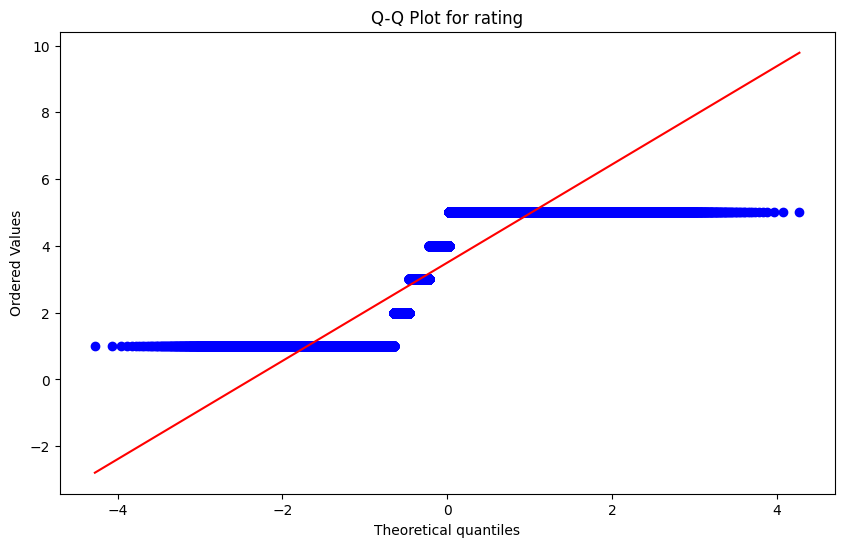

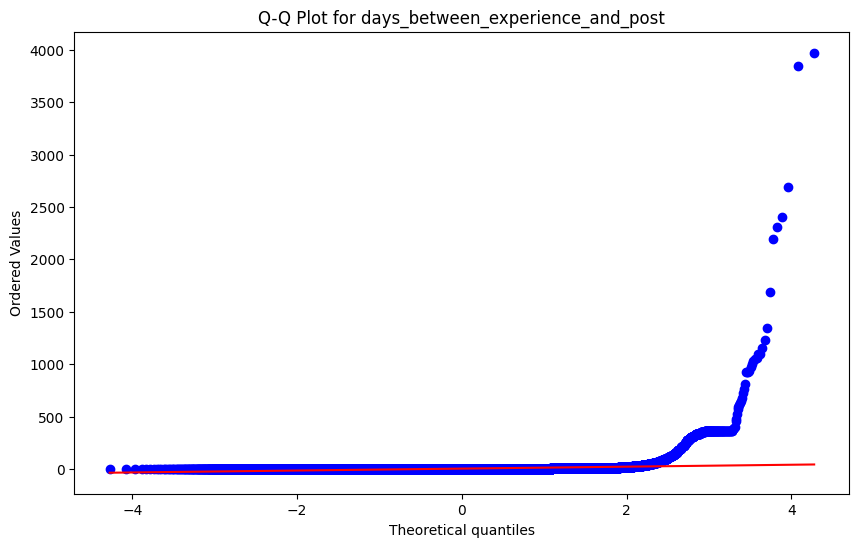

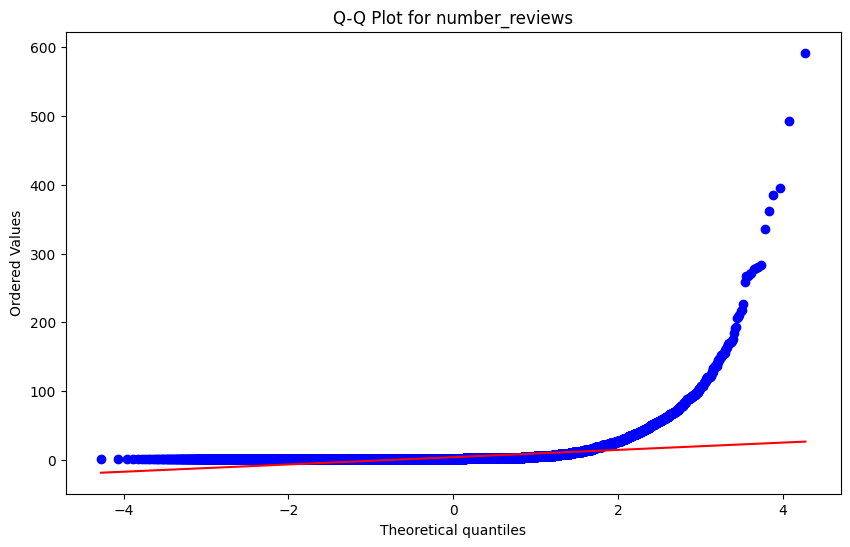

In [11]:
# Q-Q Plot

import scipy.stats as stats
import matplotlib.pyplot as plt

def create_qq_plot(data, column_name):
    plt.figure(figsize=(10, 6))
    stats.probplot(data[column_name], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot for {column_name}")
    plt.show()

# Variables to check
variables_for_qq = [
    'rating',
    'days_between_experience_and_post',
    'number_reviews'
]

for var in variables_for_qq:
    create_qq_plot(df_trustpilot, var)

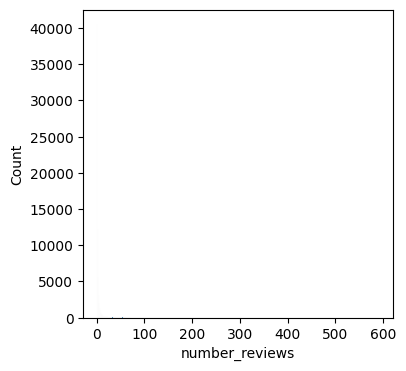

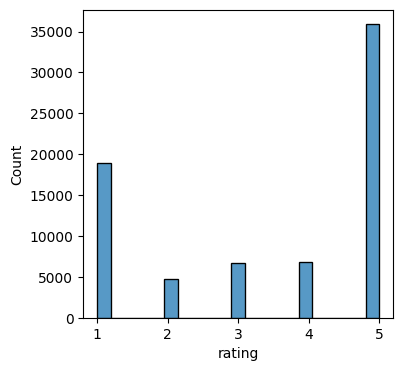

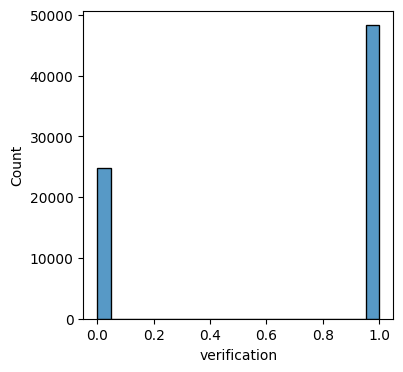

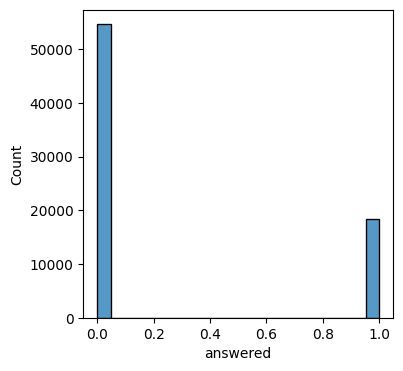

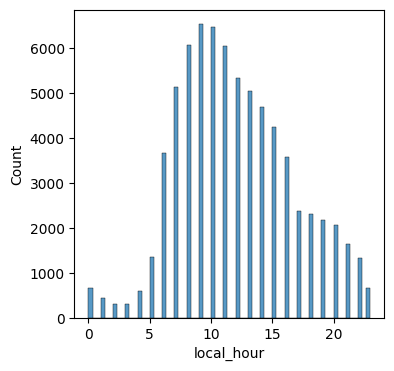

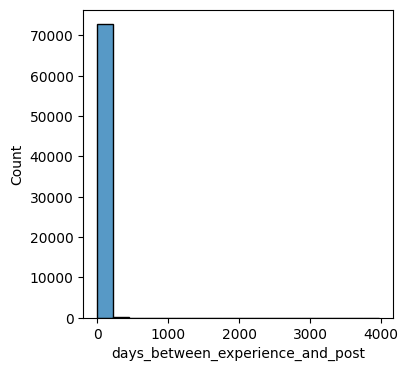

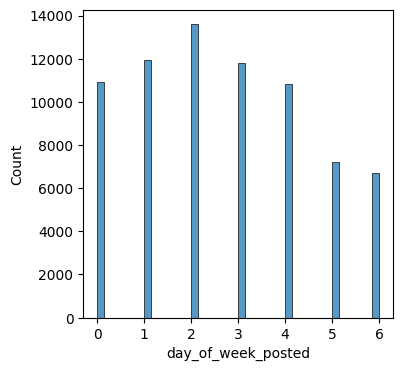

In [12]:
#Histogram

numeric_variables = df_trustpilot.select_dtypes(include = ['int', 'float'])

for value in numeric_variables:
    plt.figure(figsize=(4,4))
    sns.histplot(x=value, data=df_trustpilot)
    plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44608 (\N{HANGUL SYLLABLE GIM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51456 (\N{HANGUL SYLLABLE JUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 54805 (\N{HANGUL SYLLABLE HYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129326 (\N{FACE WITH OPEN MOUTH VOMITING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


ValueError: 
Dre$$
   ^
ParseException: Expected end of text, found '$'  (at char 3), (line:1, col:4)

<Figure size 400x400 with 1 Axes>

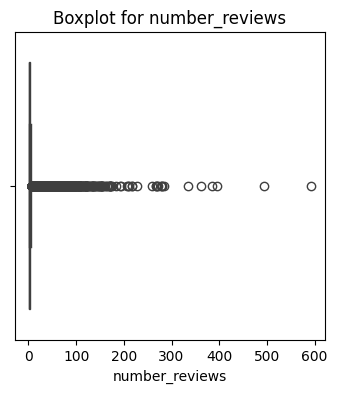

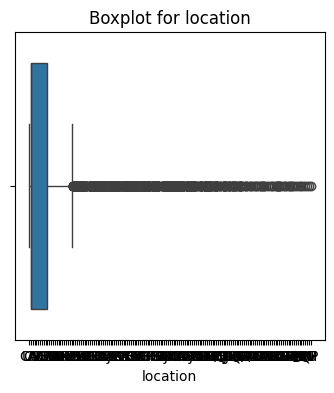

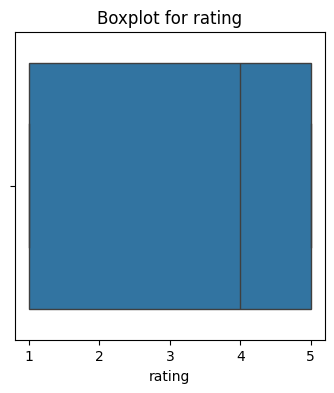

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128077 (\N{THUMBS UP SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128156 (\N{PURPLE HEART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
) missing from font(s) DejaVu Sans.k/Versions/3.12/lib/python3.12/site-packages/IP

ValueError: 
UPDATE: They replied to my message telling me to e-mail them for further assistance. Been a week, 3 e-mails still no response...Ticket 1412191So I bought the X9 and I stream alot and have a big following (1.1M) so I do use my headphones alot (6-10 hours/day).BUT I take REALLY good care of my stuff, specially for 300$ a headset. Never dropped, not one scratch, always hung safely. I bought the headphones on amazon and eventually closed my amazon account. I have not received any kind of receipt but I did buy them with my personnal card with the same adress and the same bank account that could be used by Steelseries to confirm I did buy these headphones. It's not a big deal to check with the warranty the date and time of activation of the said warranty, and to confirm with a bank statement from the customer. Any company would do it... Well it was my first time buying from Steelseries. It's the first company that don't help me because I don't have "a picture of the receipt". I see it as they know their product is a flaw So I believe they try to save money. I am surely not the only customer to have that problem because I've had losts and I mean LOTS of headsets and never the microphone teared down to stay stuck into the headset. And it's the headset that I took the most care of because I have my own place now and everything is placed where it should be.I had a Scuff controler worth 350$ that had an issue with RB button 3 months after I got it. Didnt keep the receipt, they looked in their system with the warranty and helped me. Got a new controler. I had and Xbox Elite V2 controller that had the X button not working last month, 11 month and 25 days in the warranty that last 12 months AND it was an open box. I did not have my receipt since it was bought on amazon. They understood and sent me a new controller.First time with Steelseries, and first company to do me like that so think about it before you choose them. They won't help you and will try to opt out of their warranty if it's legally possible. This is a big factor when choosing gaming gear, huge factor for someone like me that buys alot of gear and promote.So if you're here on trustpilot it's because you wonder if you should or should not go with Steelseries. I loved their headset. Unfortunately, I will never buy from them again because I feel like it's dishonest to do that to a customer that spent big buck on a product that lasted 5 months.I don't recommend this company anymore and this was my first product from them. Now 6 month after my brand new 9x Headset, I alreally need to spend big bucks on another brand because I cant use the headset 6 months in!!
                                                                                                                                                                                                                                                                                                                             ^
ParseException: Expected end of text, found '$'  (at char 317), (line:1, col:318)

<Figure size 400x400 with 1 Axes>

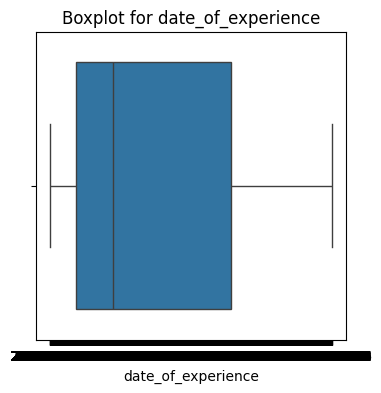

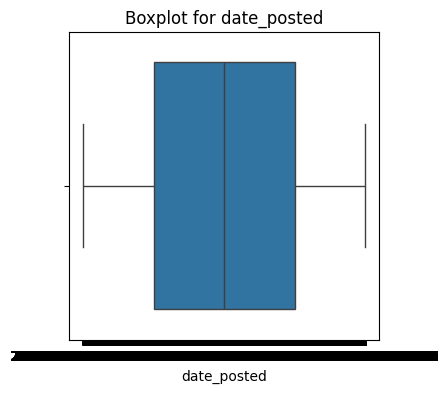

ValueError: 
Best kick a$$ flash drives ever!!
           ^
ParseException: Expected end of text, found '$'  (at char 11), (line:1, col:12)

<Figure size 400x400 with 1 Axes>

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128075 (\N{WAVING HAND SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128588 (\N{PERSON RAISING BOTH HANDS IN CELEBRATION}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128170 (\N{FLEXED BICEPS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.12/lib/

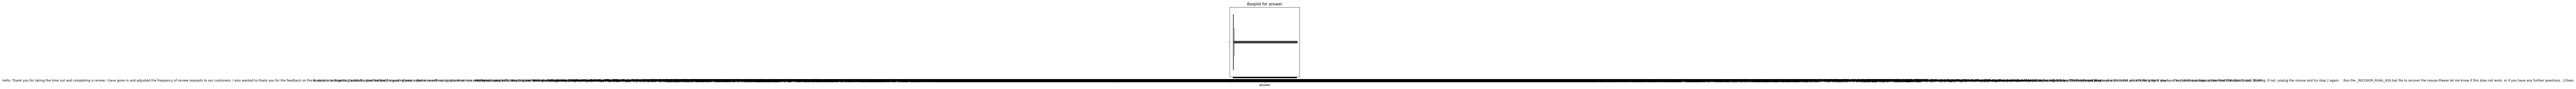

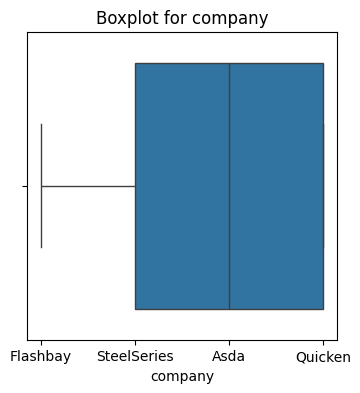

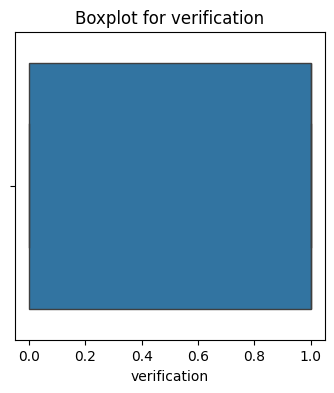

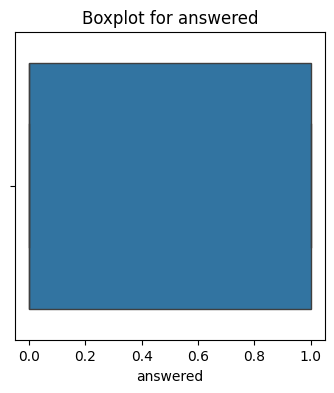

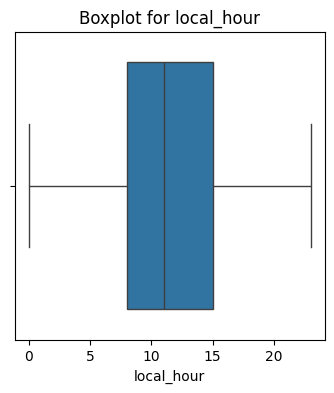

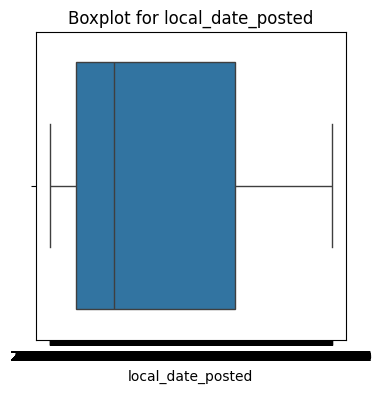

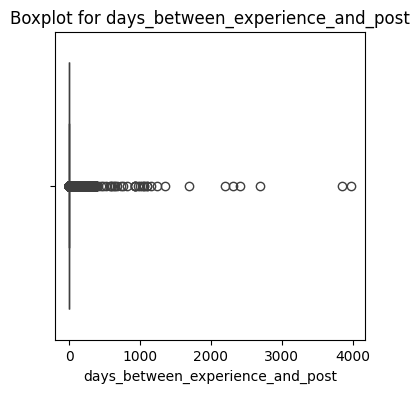

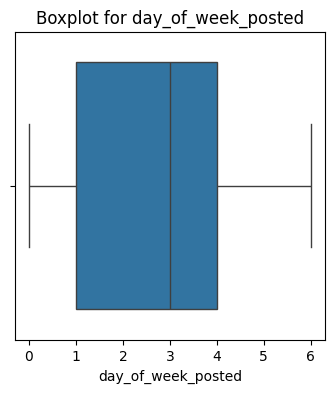

In [13]:
#Boxplot

for column in df_trustpilot.columns:
    plt.figure(figsize=(4,4))
    sns.boxplot(x=column, data=df_trustpilot)
    plt.title(f"Boxplot for {column}")
    plt.show()

Index(['username', 'number_reviews', 'location', 'rating', 'text',
       'date_of_experience', 'date_posted', 'subject', 'answer', 'company',
       'verification', 'answered', 'local_hour', 'local_date_posted',
       'days_between_experience_and_post', 'day_of_week_posted'],
      dtype='object')


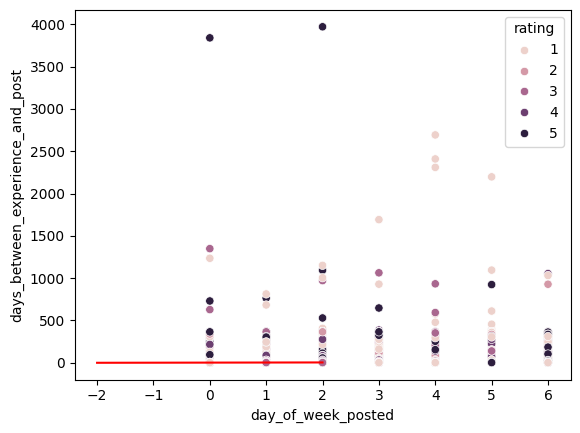

In [14]:
#Scatterplot
#Two numeric columns

print(df_trustpilot.columns)

sns.scatterplot(x='day_of_week_posted', y='days_between_experience_and_post', data=df_trustpilot, hue='rating')
plt.plot([-2, 2], [-2, 2], color = 'red')

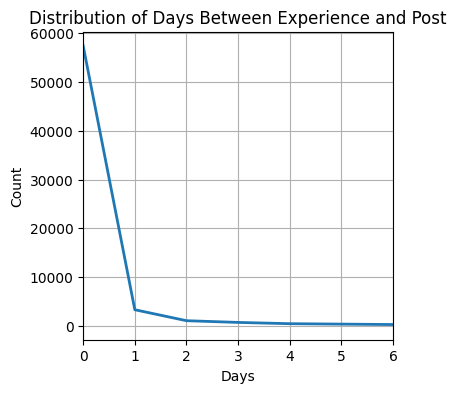

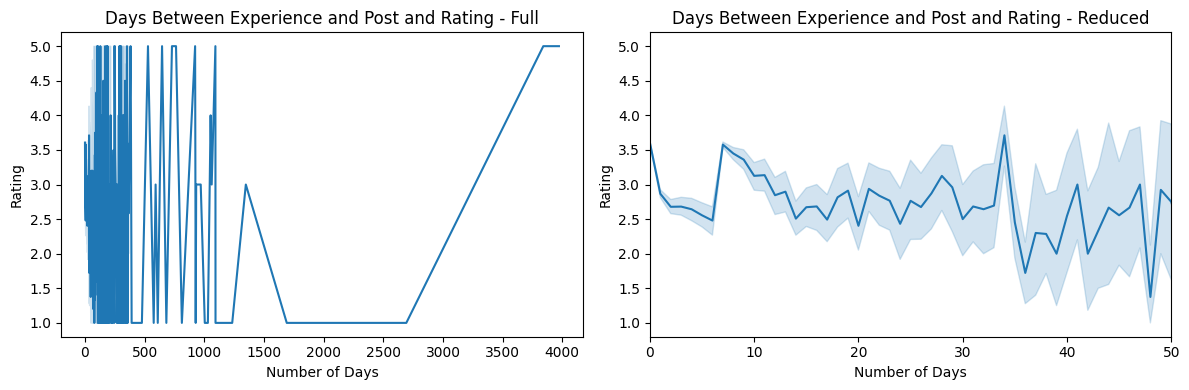

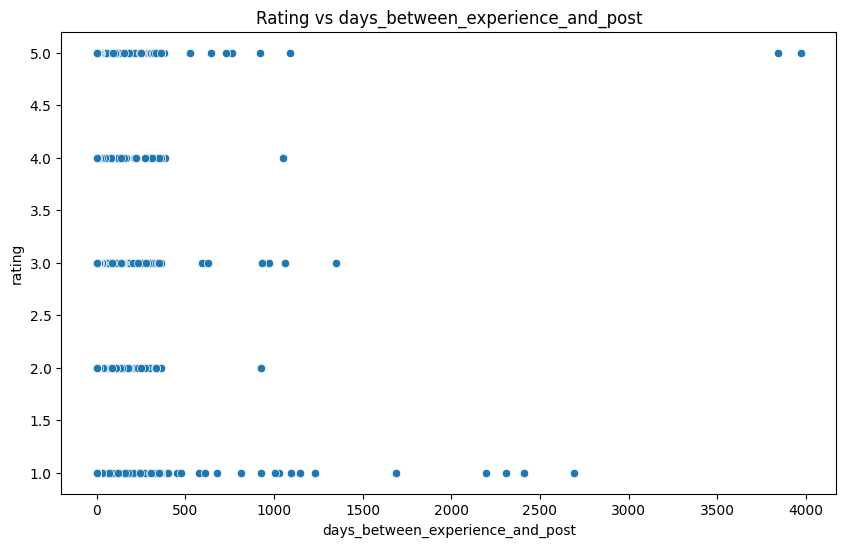

Correlation between rating and days_between_experience_and_post:
                                    rating  days_between_experience_and_post
rating                            1.000000                         -0.038881
days_between_experience_and_post -0.038881                          1.000000


In [15]:
#Next we examine the relationship between the target variable (rating) and the first numeric variable(days_between_experience_and_post)

# Distribution of days_between_experience_and_post
plt.figure(figsize=(4,4))
days_counts = df_trustpilot['days_between_experience_and_post'].value_counts().sort_index()
plt.plot(days_counts.index, days_counts.values, linewidth=2)
plt.title('Distribution of Days Between Experience and Post')
plt.xlabel('Days')
plt.ylabel('Count')
plt.xlim(0, 6)
plt.grid(True)
plt.show()

#Relationship between rating and days_between_experience_and_post
#Full Graph
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
sns.lineplot(x='days_between_experience_and_post', y='rating', data=df_trustpilot)
plt.title('Days Between Experience and Post and Rating - Full')
plt.xlabel('Number of Days')
plt.ylabel('Rating')
#Reduced Graph
plt.subplot(1, 2, 2)
sns.lineplot(x='days_between_experience_and_post', y='rating', data=df_trustpilot)
plt.title('Days Between Experience and Post and Rating - Reduced')
plt.xlabel('Number of Days')
plt.ylabel('Rating')
plt.xlim(0, 50)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_trustpilot, x='days_between_experience_and_post', y='rating')
plt.title('Rating vs days_between_experience_and_post')
plt.show()
    
correlation = df_trustpilot[['rating', 'days_between_experience_and_post']].corr()
print("Correlation between rating and days_between_experience_and_post:")
print(correlation)

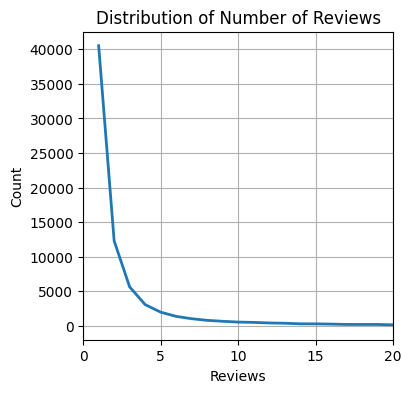

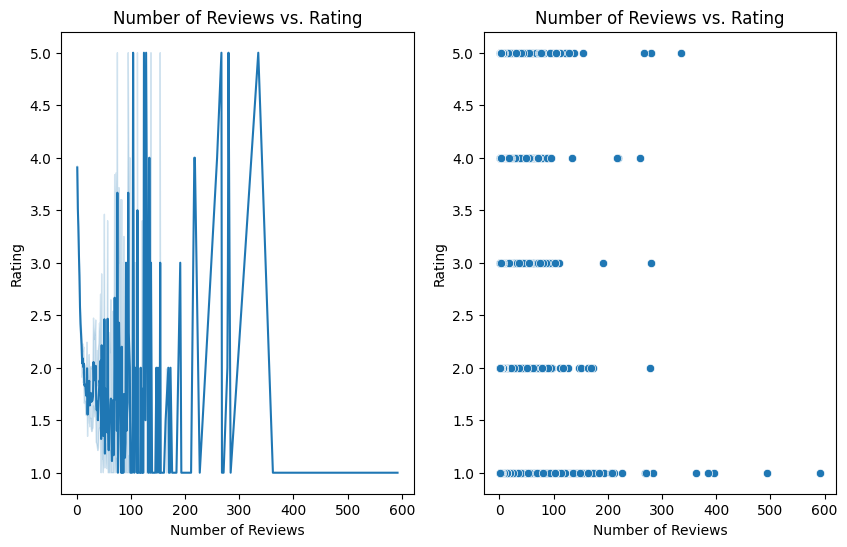

Correlation between rating and number_reviews:
                  rating  number_reviews
rating          1.000000       -0.225223
number_reviews -0.225223        1.000000
The Pearson coefficient for the relationship between rating and number_reviews is:  -0.22522270082578974
The Pearson p_value for the relationship between rating and number_reviews is:  0.0
The Spearman coefficient for the relationship between rating and number_reviews is:  -0.32602482894917023
The Spearman p_value for the relationship between rating and number_reviews is:  0.0


In [16]:
#Next we examine the relationship between the target variable (rating) and the second numeric variable (number_reviews)

# Distribution of number_reviews
plt.figure(figsize=(4,4))
number_counts = df_trustpilot['number_reviews'].value_counts().sort_index()
plt.plot(number_counts.index, number_counts.values, linewidth=2)  
plt.title('Distribution of Number of Reviews')
plt.xlabel('Reviews')
plt.ylabel('Count')
plt.xlim(0, 20)
plt.grid(True)
plt.show()

#Relationship between rating and number_reviews
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
sns.lineplot(x='number_reviews', y='rating', data=df_trustpilot)
plt.title('Number of Reviews vs. Rating')
plt.xlabel('Number of Reviews')
plt.ylabel('Rating')
plt.subplot(1,2,2)
sns.scatterplot(data=df_trustpilot, x='number_reviews', y='rating')
plt.title('Number of Reviews vs. Rating')
plt.xlabel('Number of Reviews')
plt.ylabel('Rating')
plt.show()


correlation = df_trustpilot[['rating', 'number_reviews']].corr()
print("Correlation between rating and number_reviews:")
print(correlation)

# Crosstab
pd.crosstab(df_trustpilot['rating'], df_trustpilot['number_reviews'], normalize=1)

# Pearson correlation test to study the linear relationship between two quantitative variables
# H0: The two variables are uncorrelated
# H1: The two variables are correlated

coeff, p_value = pearsonr(df_trustpilot['rating'], df_trustpilot['number_reviews'])

print("The Pearson coefficient for the relationship between rating and number_reviews is: ", coeff)
print("The Pearson p_value for the relationship between rating and number_reviews is: ", p_value)

# Pearson coefficient: -0.27085044411097997
# Negative sign indicates an inverse relationship and the value indicates a weak to moderate linear relationship. 
# This indicates that as the number of reviews for a user incrases, ratings tend to decrease slighlty.
# Pearson p_value: 0.0
# Value is 0, which means that the correlation is statistically significant.

spearman_corr, spearman_p_value = stats.spearmanr(df_trustpilot['rating'], df_trustpilot['number_reviews'])
print("The Spearman coefficient for the relationship between rating and number_reviews is: ", spearman_corr)
print("The Spearman p_value for the relationship between rating and number_reviews is: ", spearman_p_value)

# Spearman coefficient: -0.49171525764759877
# Negative sign indicates an inverse relationship and the value indicates a moderate to strong monotonic relationship between the two variables.
# Spearman p_value: 0.0
# Value is 0, which means that the correlation is statistically significant.

# H0 is rejected
# H1 is confirmed
# The difference between Pearson (-0.28) and Spearman (-0.49) suggests a non-linear relationship
# People who submit more reviews tend to give lower ratings.
# Keep for model training of a rating model

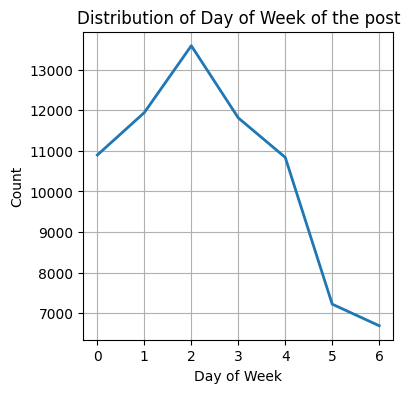

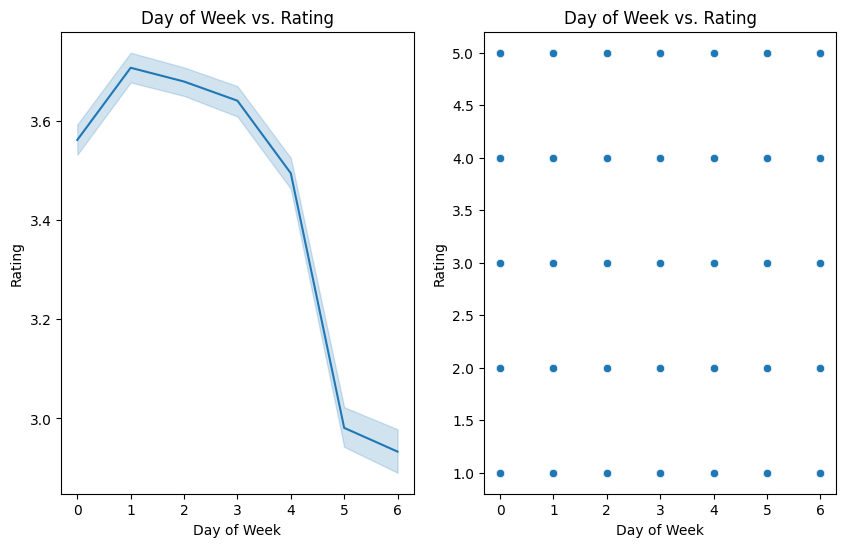

Correlation between rating and day_of_week_posted:
                      rating  day_of_week_posted
rating              1.000000           -0.123202
day_of_week_posted -0.123202            1.000000
The Pearson coefficient for the relationship between rating and day_of_week_posted is:  -0.12320199315362278
The Pearson p_value for the relationship between rating and day_of_week_posted is:  8.480174468688186e-245
The Spearman coefficient for the relationship between rating and day_of_week_posted is:  -0.12115606566110751
The Spearman p_value for the relationship between rating and day_of_week_posted is:  9.562276994428582e-237


In [17]:
#Next we examine the relationship between the target variable (rating) and the third numeric variable (day_of_week_posted)

# Distribution of day_of_week_posted
plt.figure(figsize=(4,4))
day_counts = df_trustpilot['day_of_week_posted'].value_counts().sort_index()
plt.plot(day_counts.index, day_counts.values, linewidth=2)  
plt.title('Distribution of Day of Week of the post')
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.grid(True)
plt.show()

#Relationship between rating and day_of_week_posted
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
sns.lineplot(x='day_of_week_posted', y='rating', data=df_trustpilot)
plt.title('Day of Week vs. Rating')
plt.xlabel('Day of Week')
plt.ylabel('Rating')
plt.subplot(1,2,2)
sns.scatterplot(data=df_trustpilot, x='day_of_week_posted', y='rating')
plt.title('Day of Week vs. Rating')
plt.xlabel('Day of Week')
plt.ylabel('Rating')
plt.show()


correlation = df_trustpilot[['rating', 'day_of_week_posted']].corr()
print("Correlation between rating and day_of_week_posted:")
print(correlation)

# Crosstab
pd.crosstab(df_trustpilot['rating'], df_trustpilot['day_of_week_posted'], normalize=1)

# Pearson correlation test to study the linear relationship between two quantitative variables
# H0: The two variables are uncorrelated
# H1: The two variables are correlated

coeff, p_value = pearsonr(df_trustpilot['rating'], df_trustpilot['day_of_week_posted'])

print("The Pearson coefficient for the relationship between rating and day_of_week_posted is: ", coeff)
print("The Pearson p_value for the relationship between rating and day_of_week_posted is: ", p_value)

# Pearson coefficient: -0.16944485615623162
# Negative sign indicates an inverse relationship and the value indicates a weak linear relationship. 
# This indicates that as the week goes on, the rating decreases slightly.
# Pearson p_value: 6.622488875946e-312
# Value is very close to 0, which means that the correlation is statistically significant.

spearman_corr, spearman_p_value = stats.spearmanr(df_trustpilot['rating'], df_trustpilot['day_of_week_posted'])
print("The Spearman coefficient for the relationship between rating and day_of_week_posted is: ", spearman_corr)
print("The Spearman p_value for the relationship between rating and day_of_week_posted is: ", spearman_p_value)

# Spearman coefficient: -0.1581013968262789
# Negative sign indicates an inverse relationship and the value indicates a weak monotonic relationship between the two variables.
# Spearman p_value: 2.602090303961772e-271
# Value is very close to 0, which means that the correlation is statistically significant.

# H0 is rejected
# H1 is confirmed
# The difference between Pearson (-0.17) and Spearman (-0.16) is minimal and suggests a linear relationship
# There is a very weak tendency for ratings to decrease slightly as the week progresses, but the effect is minimal. 
# Keep for model training of a rating model

In [18]:
#Next we examine the relationship between the target variable (rating) and the fourth numeric variable (hour_posted)

# Distribution of hour_posted
plt.figure(figsize=(4,4))
hour_counts = df_trustpilot['hour_posted'].value_counts().sort_index()
plt.plot(hour_counts.index, hour_counts.values, linewidth=2)  
plt.title('Distribution of hour of the postt')
plt.xlabel('Hour of Post')
plt.ylabel('Count')
plt.grid(True)
plt.show()

#Relationship between rating and hour_posted
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
sns.lineplot(x='hour_posted', y='rating', data=df_trustpilot)
plt.title('Hour posted vs. Rating')
plt.xlabel('Hour posted')
plt.ylabel('Rating')
plt.subplot(1,2,2)
sns.scatterplot(data=df_trustpilot, x='hour_posted', y='rating')
plt.title('Hour posted vs. Rating')
plt.xlabel('Hour posted')
plt.ylabel('Rating')
plt.show()


correlation = df_trustpilot[['rating', 'hour_posted']].corr()
print("Correlation between rating and hour_posted:")
print(correlation)

# Crosstab
pd.crosstab(df_trustpilot['rating'], df_trustpilot['hour_posted'], normalize=1)

# Pearson correlation test to study the linear relationship between two quantitative variables
# H0: The two variables are uncorrelated
# H1: The two variables are correlated

coeff, p_value = pearsonr(df_trustpilot['rating'], df_trustpilot['hour_posted'])

print("The Pearson coefficient for the relationship between rating and hour_posted is: ", coeff)
print("The Pearson p_value for the relationship between rating and hour_posted is: ", p_value)

# Pearson coefficient: 0.10027327443585209
# The value indicates a weak positive linear relationship. 
# Pearson p_value: 1.54644838836495e-109
# Value is very close to 0, which means that the correlation is statistically significant.

spearman_corr, spearman_p_value = stats.spearmanr(df_trustpilot['rating'], df_trustpilot['hour_posted'])
print("The Spearman coefficient for the relationship between rating and hour_posted is: ", spearman_corr)
print("The Spearman p_value for the relationship between rating and hour_posted is: ", spearman_p_value)

# Spearman coefficient: 0.1365062102414936
# The value indicates a weak monotonic relationship between the two variables.
# Spearman p_value: 3.8017897684341836e-202
# Value is very close to 0, which means that the correlation is statistically significant.

# H0 is rejected
# H1 is confirmed
# There is a difference between Pearson (0.10) and Spearman (0.14) may be monotonous, not linear.
# There is a very weak tendency for ratings to increase slightly as the day progresses, but the effect is minimal. 
# The relationship appears stronger when considering ranked values (Spearman) rather than absolute values (Pearson)
# Keep for model training of a rating model

KeyError: 'hour_posted'

<Figure size 400x400 with 0 Axes>

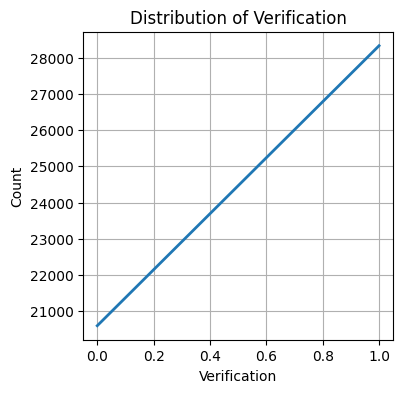

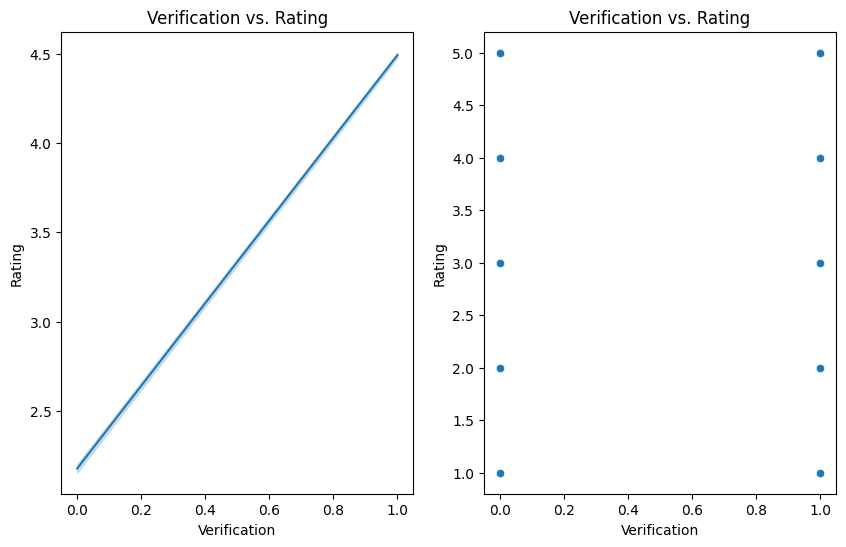

Correlation between rating and verification:
                rating  verification
rating        1.000000      0.621658
verification  0.621658      1.000000
The Pearson coefficient for the relationship between rating and verification is:  0.6216580567159748
The Pearson p_value for the relationship between rating and verification is:  0.0
The Spearman coefficient for the relationship between rating and verification is:  0.614853227230979
The Spearman p_value for the relationship between rating and verification is:  0.0


In [371]:
#Next we examine the relationship between the target variable (rating) and the fourth numeric variable (verification)

# Distribution of verification
plt.figure(figsize=(4,4))
verification_counts = df_trustpilot['verification'].value_counts().sort_index()
plt.plot(verification_counts.index, verification_counts.values, linewidth=2)  
plt.title('Distribution of Verification')
plt.xlabel('Verification')
plt.ylabel('Count')
plt.grid(True)
plt.show()

#Relationship between rating and verification
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
sns.lineplot(x='verification', y='rating', data=df_trustpilot)
plt.title('Verification vs. Rating')
plt.xlabel('Verification')
plt.ylabel('Rating')
plt.subplot(1,2,2)
sns.scatterplot(data=df_trustpilot, x='verification', y='rating')
plt.title('Verification vs. Rating')
plt.xlabel('Verification')
plt.ylabel('Rating')
plt.show()


correlation = df_trustpilot[['rating', 'verification']].corr()
print("Correlation between rating and verification:")
print(correlation)

# Crosstab
pd.crosstab(df_trustpilot['rating'], df_trustpilot['verification'], normalize=1)

# Pearson correlation test to study the linear relationship between two quantitative variables
# H0: The two variables are uncorrelated
# H1: The two variables are correlated

coeff, p_value = pearsonr(df_trustpilot['rating'], df_trustpilot['verification'])

print("The Pearson coefficient for the relationship between rating and verification is: ", coeff)
print("The Pearson p_value for the relationship between rating and verification is: ", p_value)

# Pearson coefficient: 0.6216580567159748
# The value indicates a strong positive linear relationship. 
# Pearson p_value: 0.0
# Value is 0, which means that the correlation is statistically significant.

spearman_corr, spearman_p_value = stats.spearmanr(df_trustpilot['rating'], df_trustpilot['verification'])
print("The Spearman coefficient for the relationship between rating and verification is: ", spearman_corr)
print("The Spearman p_value for the relationship between rating and verification is: ", spearman_p_value)

# Spearman coefficient: 0.614853227230979
# The value indicates a strong monotonic relationship between the two variables.
# Spearman p_value: 0.0
# Value is 0, which means that the correlation is statistically significant.

# H0 is rejected
# H1 is confirmed
# There is a very small difference between Pearson (0.62) and Spearman (0.61), indicating that the relationship is linear.
# When the likelihood of a user being verified increases, the ratings they give tend to be higher as well.
# Keep for model training of a rating model



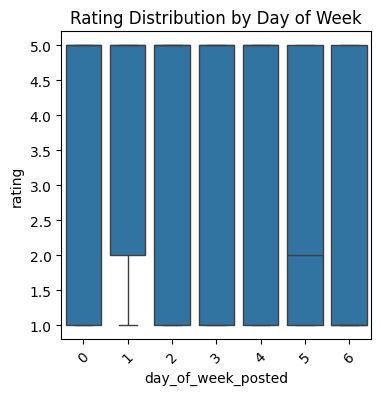

In [373]:
#shows the rating distribution by day of week

plt.figure(figsize=(4, 4))
sns.boxplot(data=df_trustpilot, x='day_of_week_posted', y='rating')
plt.title('Rating Distribution by Day of Week')
plt.xticks(rotation=45)
plt.show()

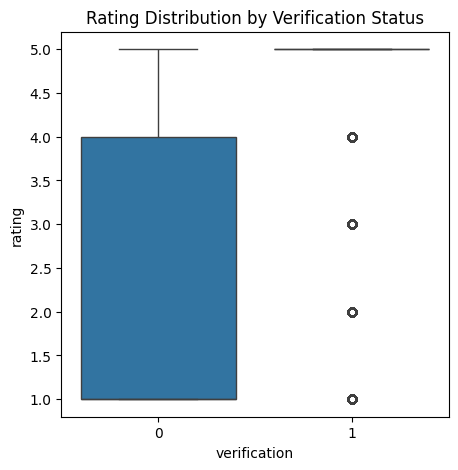

In [331]:
# Rating distribution by verification status

plt.figure(figsize=(5, 5))
sns.boxplot(data=df_trustpilot, x='verification', y='rating')
plt.title('Rating Distribution by Verification Status')
plt.show()

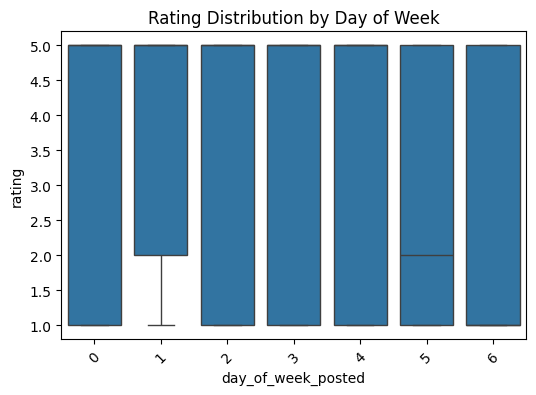

In [332]:
# Rating by day of week
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_trustpilot, x='day_of_week_posted', y='rating')
plt.title('Rating Distribution by Day of Week')
plt.xticks(rotation=45)
plt.show()


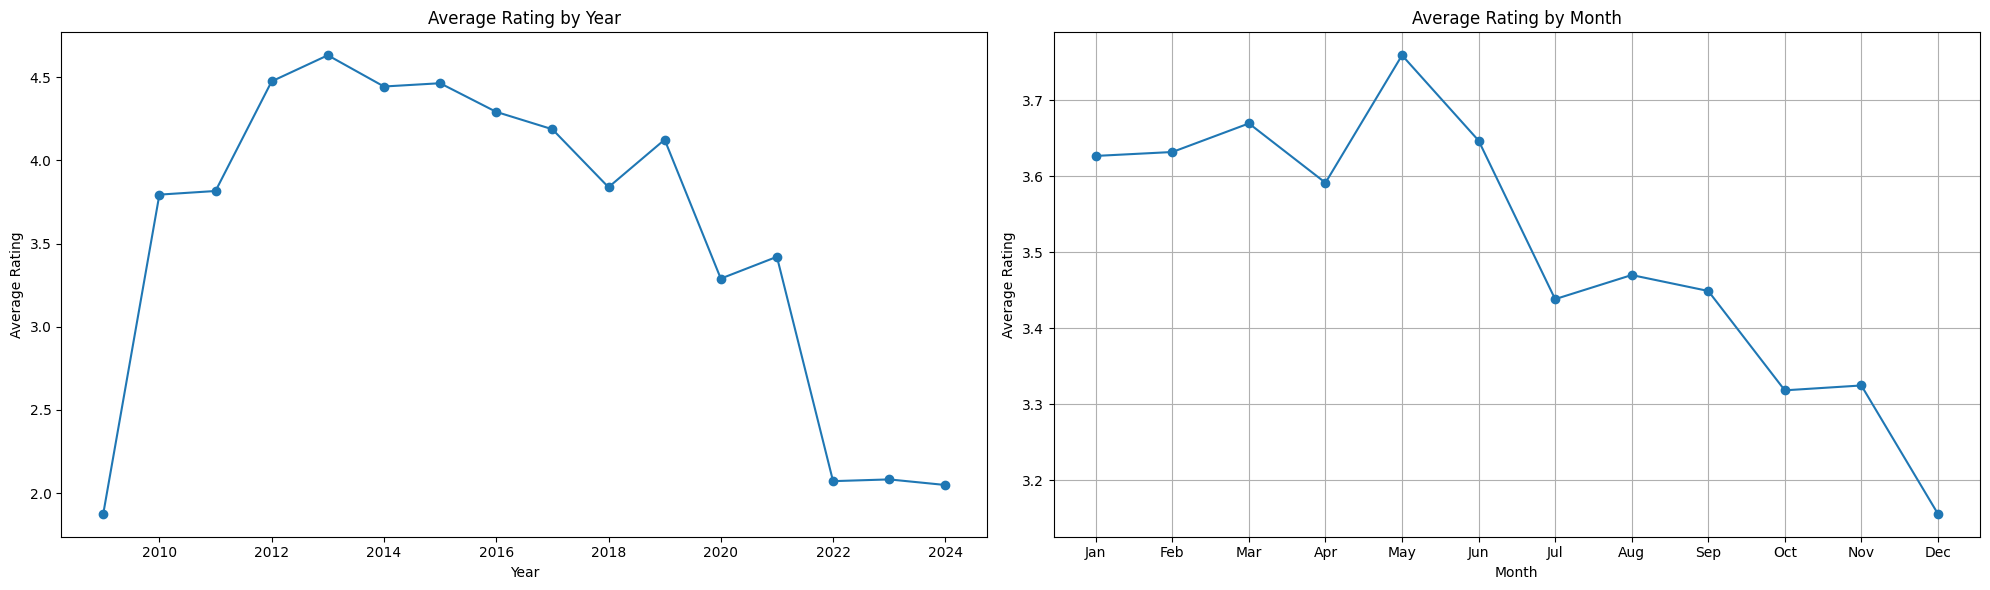


Yearly Average Ratings:
date_posted
2009    1.875000
2010    3.794521
2011    3.816327
2012    4.475761
2013    4.632653
2014    4.444745
2015    4.464453
2016    4.292188
2017    4.187657
2018    3.839085
2019    4.125113
2020    3.289464
2021    3.420611
2022    2.071377
2023    2.081790
2024    2.048193
Name: rating, dtype: float64

Monthly Average Ratings:
date_posted
1     3.626719
2     3.631865
3     3.669462
4     3.591385
5     3.759142
6     3.646917
7     3.438319
8     3.470015
9     3.449070
10    3.318343
11    3.324734
12    3.155924
Name: rating, dtype: float64


In [333]:
# Create figure with two subplots side by side
plt.figure(figsize=(20, 6))

# Yearly average rating
plt.subplot(1, 2, 1)
yearly_avg = df_trustpilot.groupby(df_trustpilot['date_posted'].dt.year)['rating'].mean()
yearly_avg.plot(marker='o')
plt.title('Average Rating by Year')
plt.xlabel('Year')
plt.ylabel('Average Rating')

# Monthly average rating
plt.subplot(1, 2, 2)
monthly_avg = df_trustpilot.groupby(df_trustpilot['date_posted'].dt.month)['rating'].mean()
monthly_avg.plot(marker='o')
plt.title('Average Rating by Month')
plt.xlabel('Month')
plt.ylabel('Average Rating')
plt.grid(True)

plt.xticks(range(1,13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                         'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.tight_layout()  
plt.show()

print("\nYearly Average Ratings:")
print(yearly_avg)
print("\nMonthly Average Ratings:")
print(monthly_avg)

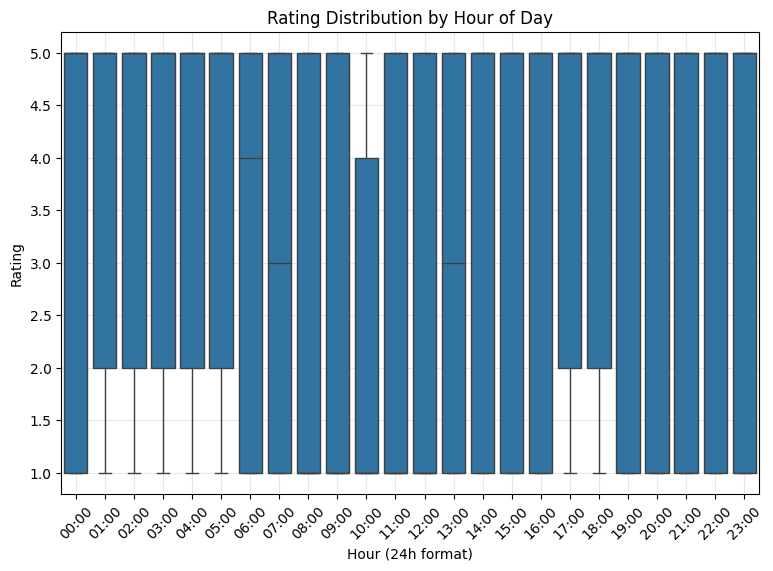

Hourly Statistics:
      mean  count
hour             
0     3.61   1418
1     3.79   1066
2     3.81    775
3     3.82    538
4     3.83    455
5     3.73    487
6     3.32    545
7     3.01    782
8     2.60    902
9     2.35   1062
10    2.26   1261
11    2.37   1418
12    2.60   1635
13    2.99   1988
14    3.37   2588
15    3.60   3139
16    3.73   3767
17    3.86   4230
18    3.87   4280
19    3.79   3925
20    3.75   3897
21    3.76   3659
22    3.72   3004
23    3.62   2108


In [334]:
# Rating distribution by hour

df_trustpilot['hour'] = df_trustpilot['hour_posted'].astype(str).str[:2].astype(int)
plt.figure(figsize=(9, 6))
sns.boxplot(data=df_trustpilot, x='hour', y='rating')
plt.title('Rating Distribution by Hour of Day')
plt.xlabel('Hour (24h format)')
plt.ylabel('Rating')
plt.xticks(range(24), [f'{i:02d}:00' for i in range(24)], rotation=45)  
plt.grid(True, alpha=0.3)
plt.show()

hourly_stats = df_trustpilot.groupby('hour')['rating'].agg(['mean', 'count']).round(2)
print("Hourly Statistics:")
print(hourly_stats)

In [ ]:

# Define reasonable date range
start_date = '2011-01-01'
end_date = '2023-12-31'

# Filter the data
filtered_df = df_trustpilot[
    (df_trustpilot['local_date_posted'] >= start_date) & 
    (df_trustpilot['local_date_posted'] <= end_date)
]

# 1. Daily Average Rating Over Time (actual time series)
plt.figure(figsize=(15, 6))
daily_avg = filtered_df.groupby('local_date_posted')['rating'].mean()
plt.plot(daily_avg.index, daily_avg.values)
plt.title('Daily Average Rating Over Time')
plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.grid(True, alpha=0.3)
plt.show()

# 2. Rolling Average to Smooth Daily Fluctuations
plt.figure(figsize=(15, 6))
rolling_avg = daily_avg.rolling(window=30).mean()  # 30-day moving average
plt.plot(daily_avg.index, daily_avg.values, alpha=0.3, label='Daily Average')
plt.plot(rolling_avg.index, rolling_avg.values, linewidth=2, label='30-day Moving Average')
plt.title('Rating Trend Over Time (with 30-day Moving Average)')
plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 3. Volume of Reviews Over Time
plt.figure(figsize=(15, 6))
daily_count = filtered_df.groupby('local_date_posted').size()
plt.plot(daily_count.index, daily_count.values)
plt.title('Number of Reviews Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.grid(True, alpha=0.3)
plt.show()

# 4. Day of Week Analysis
plt.figure(figsize=(12, 6))
filtered_df['day_of_week'] = filtered_df['local_date_posted'].dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.boxplot(data=filtered_df, x='day_of_week', y='rating', order=day_order)
plt.title('Rating Distribution by Day of Week')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()

# 5. Heatmap: Hour vs Day of Week
plt.figure(figsize=(15, 8))
pivot_table = filtered_df.pivot_table(
    values='rating',
    index=filtered_df['local_date_posted'].dt.day_name(),
    columns='local_hour',
    aggfunc='mean'
)
pivot_table = pivot_table.reindex(day_order)  # Reorder days
sns.heatmap(pivot_table, cmap='YlOrRd', annot=True, fmt='.2f')
plt.title('Average Rating by Hour and Day of Week')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()

# 6. Volume and Rating Combined
fig, ax1 = plt.subplots(figsize=(15, 6))

# Plot volume
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Reviews', color=color)
line1 = ax1.plot(daily_count.index, daily_count.values, color=color, label='Number of Reviews')
ax1.tick_params(axis='y', labelcolor=color)

# Plot rating on secondary y-axis
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Average Rating', color=color)
line2 = ax2.plot(daily_avg.index, daily_avg.values, color=color, label='Average Rating')
ax2.tick_params(axis='y', labelcolor=color)

# Add legend
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')

plt.title('Review Volume and Average Rating Over Time')
fig.tight_layout()
plt.show()

# Print some summary statistics
print("\nTime Series Statistics:")
print(f"Start Date: {filtered_df['local_date_posted'].min()}")
print(f"End Date: {filtered_df['local_date_posted'].max()}")
print(f"\nBusiest Day: {daily_count.idxmax()} with {daily_count.max()} reviews")
print(f"Best Rating Day: {daily_avg.idxmax()} with average rating of {daily_avg.max():.2f}")
print(f"Worst Rating Day: {daily_avg.idxmin()} with average rating of {daily_avg.min():.2f}")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Filter date range as before
start_date = '2011-01-01'
end_date = '2023-12-31'
filtered_df = df_trustpilot[
    (df_trustpilot['local_date_posted'] >= start_date) & 
    (df_trustpilot['local_date_posted'] <= end_date)
]

# 1. Top N companies by review count
N = 10  # Adjust this number based on how many companies you want to show
top_companies = filtered_df['company'].value_counts().head(N).index

# Filter for top companies
top_companies_df = filtered_df[filtered_df['company'].isin(top_companies)]

# 2. Monthly average rating by company
plt.figure(figsize=(15, 8))
for company in top_companies:
    company_data = filtered_df[filtered_df['company'] == company]
    monthly_avg = company_data.groupby(company_data['local_date_posted'].dt.to_period('M'))['rating'].mean()
    plt.plot(monthly_avg.index.astype(str), monthly_avg.values, label=company, marker='o', markersize=4)

plt.title(f'Monthly Average Rating Trend for Top {N} Companies')
plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Box plot of ratings by company
plt.figure(figsize=(15, 6))
sns.boxplot(data=top_companies_df, x='company', y='rating')
plt.title(f'Rating Distribution for Top {N} Companies')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 4. Heatmap of monthly ratings
pivot_table = top_companies_df.pivot_table(
    values='rating',
    index='company',
    columns=top_companies_df['local_date_posted'].dt.to_period('M'),
    aggfunc='mean'
)

plt.figure(figsize=(20, 8))
sns.heatmap(pivot_table, cmap='YlOrRd', annot=True, fmt='.2f')
plt.title('Average Rating by Company and Month')
plt.xlabel('Month')
plt.ylabel('Company')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5. Print summary statistics
print("\nCompany Statistics:")
for company in top_companies:
    company_data = filtered_df[filtered_df['company'] == company]
    print(f"\n{company}:")
    print(f"Total reviews: {len(company_data):,}")
    print(f"Average rating: {company_data['rating'].mean():.2f}")
    print(f"Rating trend (start to end): {company_data.groupby(company_data['local_date_posted'].dt.year)['rating'].mean().iloc[-1] - company_data.groupby(company_data['local_date_posted'].dt.year)['rating'].mean().iloc[0]:.2f}")
    print(f"Most recent average (last 3 months): {company_data.tail(90)['rating'].mean():.2f}")

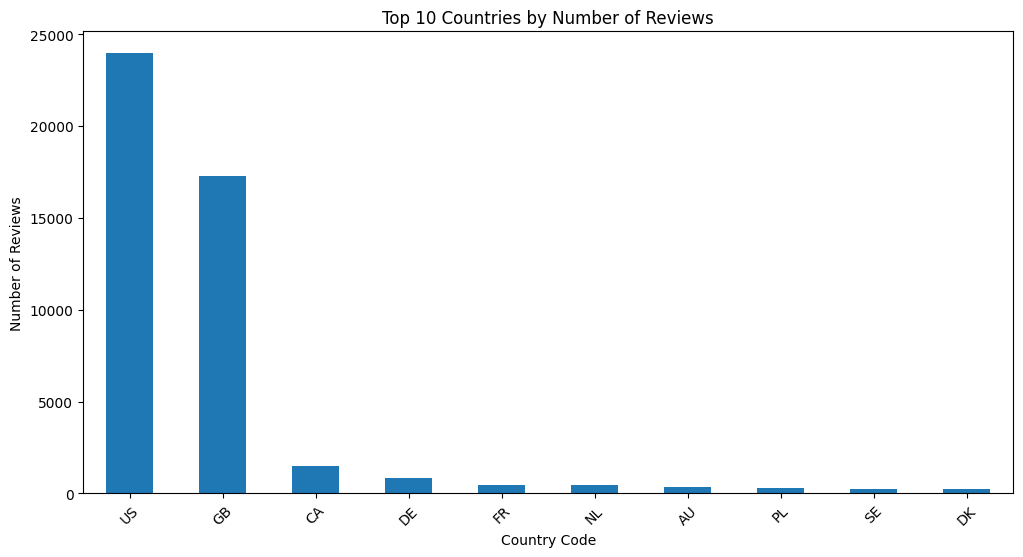

In [335]:
# Location analysis (top 10 countries)

plt.figure(figsize=(12, 6))
df_trustpilot['location'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Countries by Number of Reviews')
plt.xlabel('Country Code')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.show()

<Figure size 800x800 with 0 Axes>

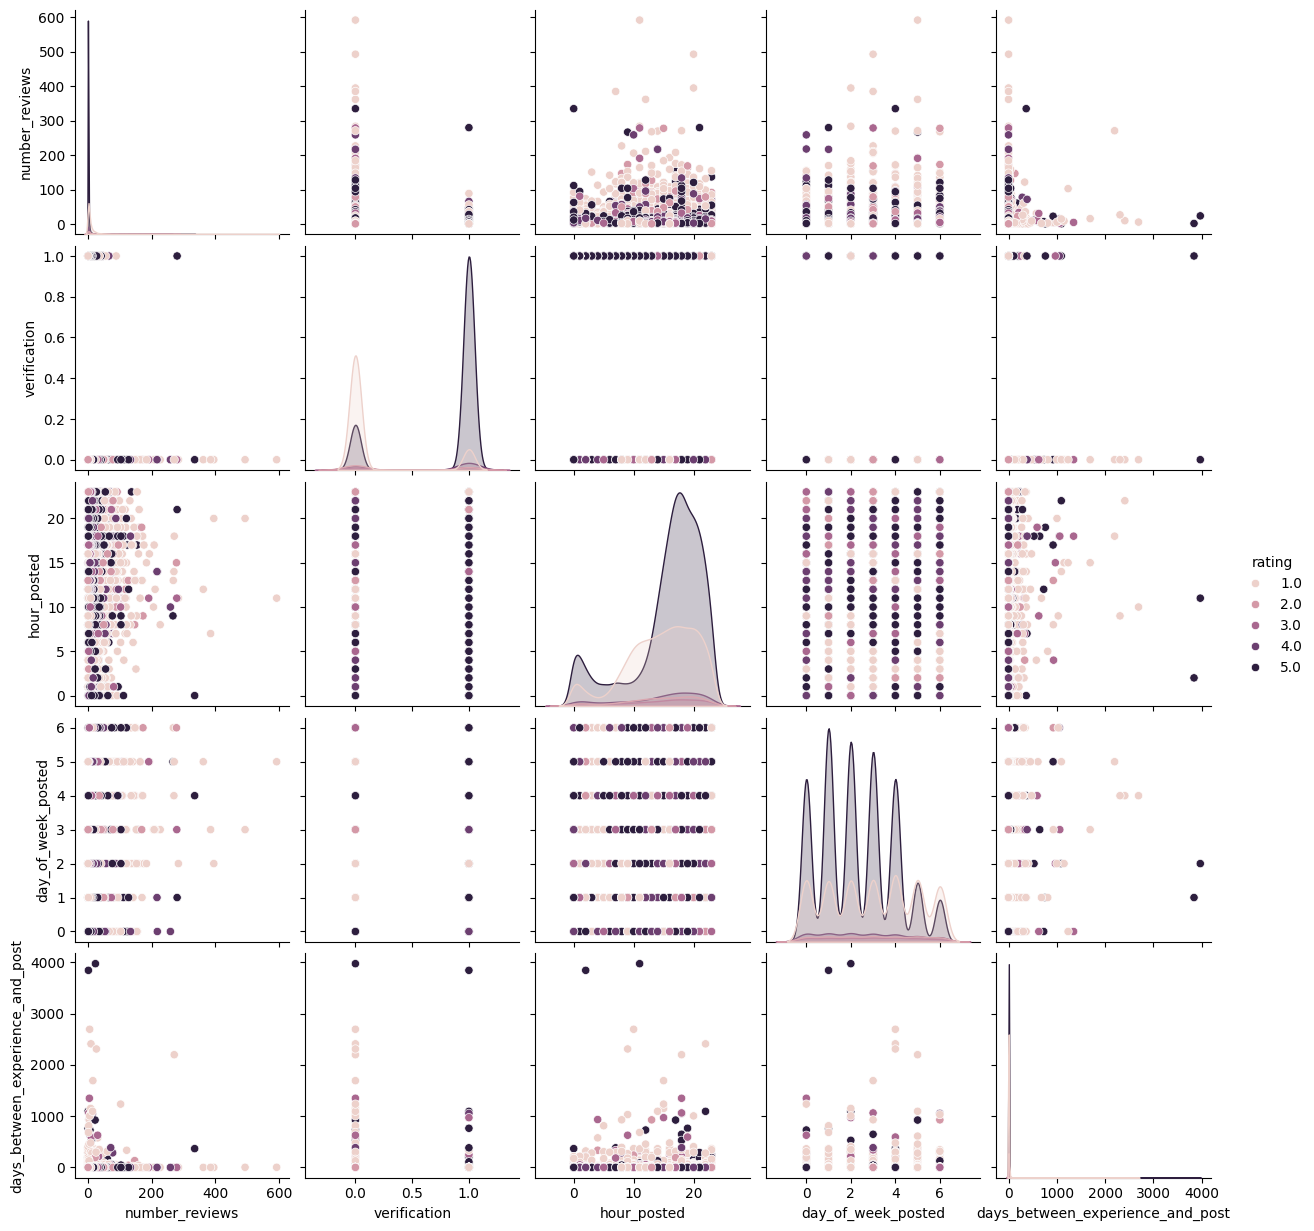

In [336]:
plt.figure(figsize=(8, 8))
sns.pairplot(data=df_trustpilot[['number_reviews', 'location', 'rating', 'text',
       'date_of_experience', 'date_posted', 'verification', 'subject',
       'hour_posted', 'day_of_week_posted',
       'days_between_experience_and_post']], hue='rating', diag_kind='kde')
plt.show()

In [337]:
print(df_trustpilot.columns)

Index(['username', 'number_reviews', 'location', 'rating', 'text',
       'date_of_experience', 'date_posted', 'subject', 'hour_posted',
       'day_of_week_posted', 'days_between_experience_and_post',
       'verification', 'hour'],
      dtype='object')


/var/folders/fj/_k57h65963x0q_bf6vpz8cym0000gn/T/ipykernel_47813/3069507826.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='location', y='rating', data=df_filtered,
/var/folders/fj/_k57h65963x0q_bf6vpz8cym0000gn/T/ipykernel_47813/3069507826.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='location', y='rating', data=df_filtered,


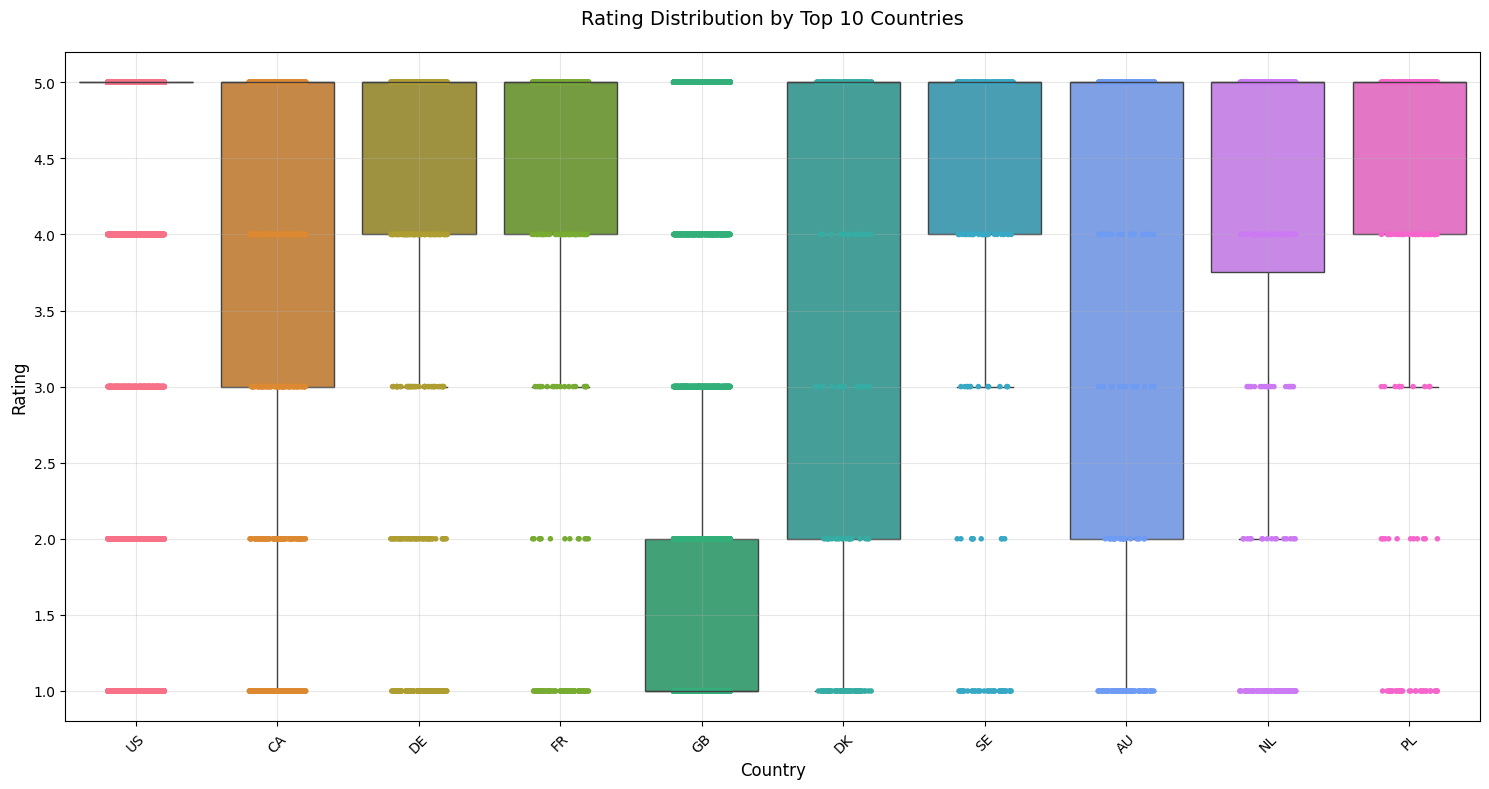

Summary Statistics by Country:
          count  mean  median   std
location                           
AU          331  3.78     5.0  1.69
CA         1494  3.86     5.0  1.57
DE          843  4.10     5.0  1.44
DK          258  3.62     5.0  1.69
FR          466  4.13     5.0  1.46
GB        17288  1.77     1.0  1.45
NL          432  4.00     5.0  1.52
PL          293  4.25     5.0  1.37
SE          261  4.09     5.0  1.47
US        23956  4.64     5.0  1.04


In [338]:
# Get top 10 countries
top_countries = df_trustpilot['location'].value_counts().head(10).index

df_filtered = df_trustpilot[df_trustpilot['location'].isin(top_countries)]
colors = sns.color_palette("husl", n_colors=len(top_countries))

plt.figure(figsize=(15, 8))

# Create boxplot 
sns.boxplot(x='location', y='rating', data=df_filtered,
            palette=colors,
            boxprops={'zorder': 1}, 
            showfliers=False)  

# Add stripplot on top
sns.stripplot(x='location', y='rating', data=df_filtered,
              palette=colors,  
              size=4,  
              jitter=0.2,  
              zorder=2)  


plt.title('Rating Distribution by Top 10 Countries', fontsize=14, pad=20)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


print("Summary Statistics by Country:")
print(df_filtered.groupby('location')['rating'].agg(['count', 'mean', 'median', 'std']).round(2))